<a href="https://colab.research.google.com/github/Utkarsh038/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/Oill_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:


TRAIN_IMG_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

print(f"Path to training images: {TRAIN_IMG_DIR}")
print(f"Path to training masks: {TRAIN_MASK_DIR}")

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16


Path to training images: drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/
Path to training masks: drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/


Displaying sample images and their corresponding masks...


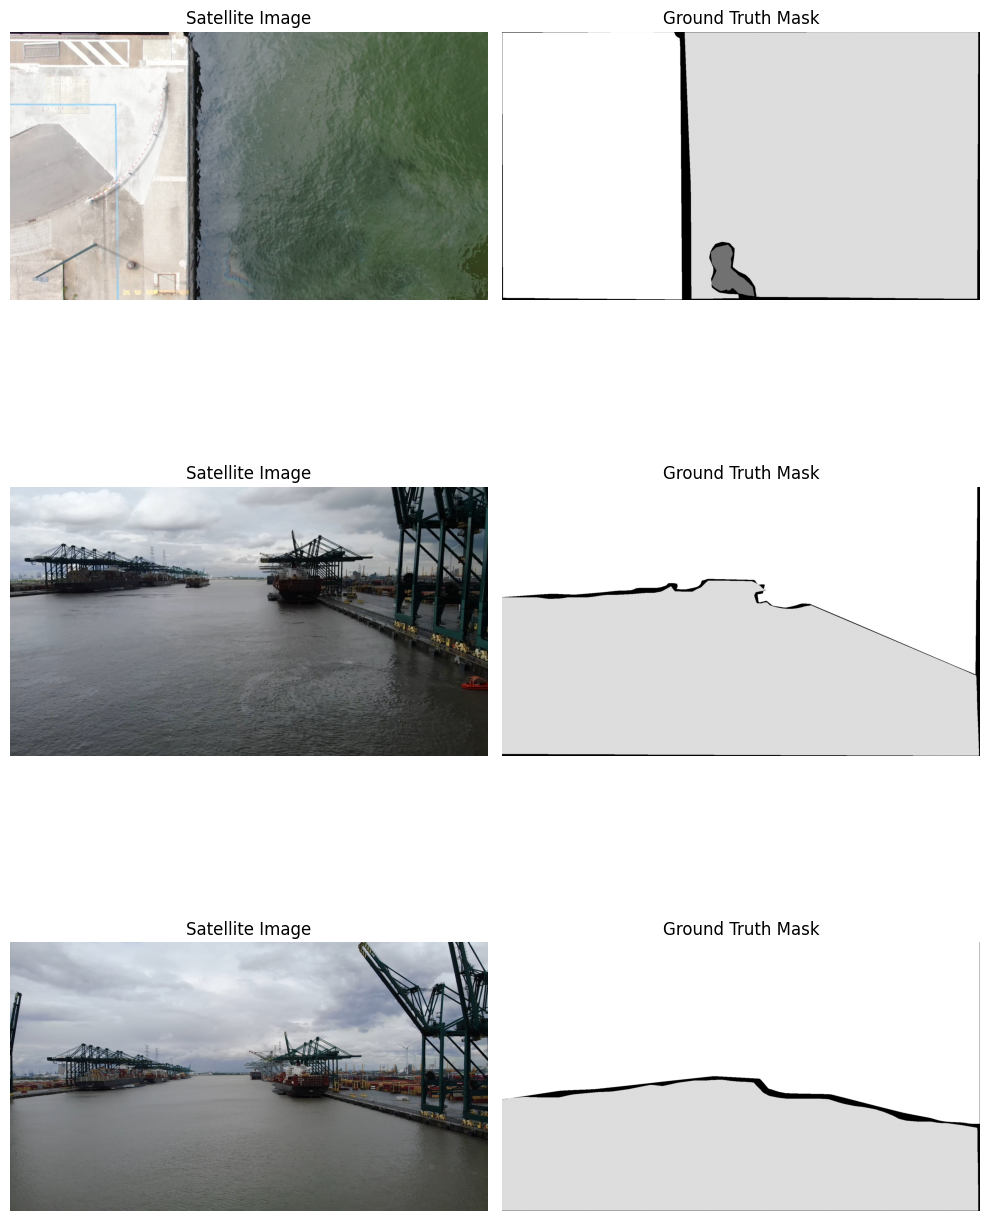

In [3]:
# ==============================================================================
# Step 3: Data Exploration - Visualize Sample Images and Masks
# ==============================================================================

# Get a list of all image and mask files
# Update paths to reflect the cloned repository location
TRAIN_IMG_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

train_image_files = sorted([os.path.join(TRAIN_IMG_DIR, f) for f in os.listdir(TRAIN_IMG_DIR)])
train_mask_files = sorted([os.path.join(TRAIN_MASK_DIR, f) for f in os.listdir(TRAIN_MASK_DIR)])

# Function to display images and masks
def display_samples(images, masks, count=3):
    plt.figure(figsize=(10, 5 * count))
    for i in range(count):
        # Load original image
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for plotting

        # Load mask image
        mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(count, 2, 2 * i + 1)
        plt.title("Satellite Image")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 3 samples
print("Displaying sample images and their corresponding masks...")
display_samples(train_image_files, train_mask_files, count=3)


Displaying a sample after preprocessing (resizing, noise reduction, and normalization)...


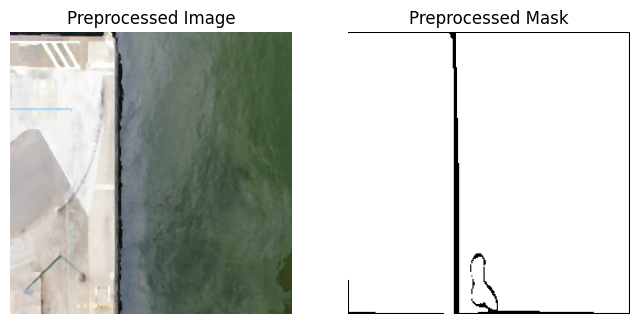

In [4]:
# ==============================================================================
# Data Preprocessing
# ==============================================================================

def preprocess_image(image_path, mask_path):


    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

#    For speckle Noise reduction
    def apply_median_filter(image_tensor):
        image_np = image_tensor.numpy().astype(np.uint8)

        filtered_image = cv2.medianBlur(image_np, 3)
        return filtered_image.astype(np.float32)

    img = tf.py_function(func=apply_median_filter, inp=[img], Tout=tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    # Normalize the image pixel values to be between 0 and 1
    img = img / 255.0

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest') # Use 'nearest' for masks
    # Normalize mask to be binary (0 or 1)
    mask = tf.cast(mask > 0, dtype=tf.float32)

    return img, mask


dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))


processed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


print("\nDisplaying a sample after preprocessing (resizing, noise reduction, and normalization)...")
for img, mask in processed_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Preprocessed Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Mask")
    plt.imshow(tf.squeeze(mask), cmap='gray')
    plt.axis('off')
    plt.show()


Displaying a sample after augmentation...


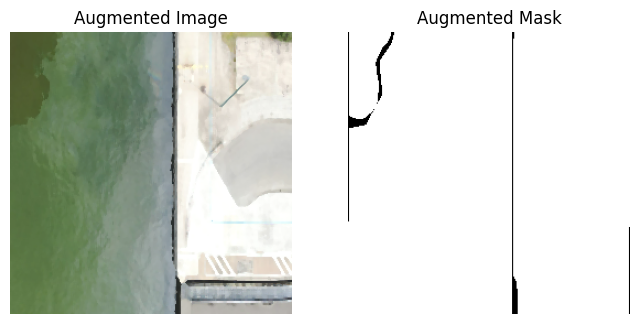


 (Data Exploration, Preprocessing, and Augmentation) is complete.


In [5]:
# ==============================================================================
# Data Augmentation
# ==============================================================================

def augment_data(image, mask):


    combined = tf.concat([image, mask], axis=-1)

    # Random horizontal flip
    combined = tf.image.random_flip_left_right(combined)

    # Random vertical flip
    combined = tf.image.random_flip_up_down(combined)

    # Separate the image and mask again
    image = combined[:, :, :3]
    mask = combined[:, :, 3:]

    # Brightness and contrast adjustments are applied only to the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0) # Ensure values remain in [0, 1]

    return image, mask


train_dataset = (
    processed_dataset
    .cache()  # Cache data for performance
    .shuffle(buffer_size=1000)
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualize an augmented sample
print("\nDisplaying a sample after augmentation...")
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image")
    plt.imshow(img[0]) # Display the first image in the batch
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Augmented Mask")
    plt.imshow(tf.squeeze(mask[0]), cmap='gray') # Display the first mask in the batch
    plt.axis('off')
    plt.show()

print("\n (Data Exploration, Preprocessing, and Augmentation) is complete.")


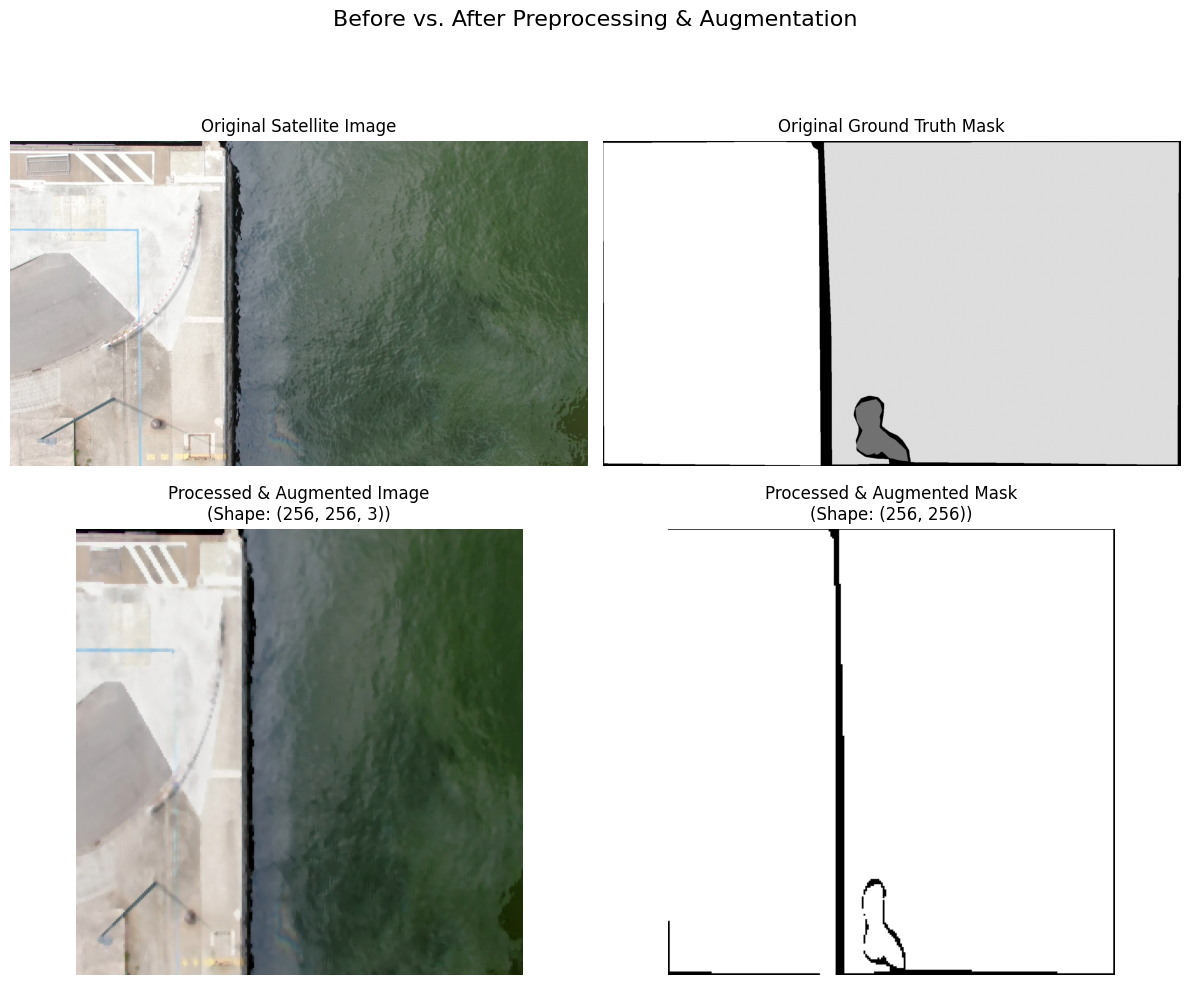

In [6]:
# ==============================================================================
#  Combined Before vs. After Visualization
# ==============================================================================


sample_image_path = train_image_files[0]
sample_mask_path = train_mask_files[0]


original_img = cv2.imread(sample_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)


processed_img, processed_mask = preprocess_image(sample_image_path, sample_mask_path)

augmented_img, augmented_mask = augment_data(processed_img, processed_mask)


plt.figure(figsize=(12, 10))
plt.suptitle("Before vs. After Preprocessing & Augmentation", fontsize=16)

# Top-left: Original Image
plt.subplot(2, 2, 1)
plt.title("Original Satellite Image")
plt.imshow(original_img)
plt.axis('off')

# Top-right: Original Mask
plt.subplot(2, 2, 2)
plt.title("Original Ground Truth Mask")
plt.imshow(original_mask, cmap='gray')
plt.axis('off')

# Bottom-left: Processed & Augmented Image
plt.subplot(2, 2, 3)
plt.title(f"Processed & Augmented Image\n(Shape: {augmented_img.shape})")
plt.imshow(augmented_img)
plt.axis('off')

# Bottom-right: Processed & Augmented Mask
plt.subplot(2, 2, 4)
plt.title(f"Processed & Augmented Mask\n(Shape: {tf.squeeze(augmented_mask).shape})")
plt.imshow(tf.squeeze(augmented_mask), cmap='gray') # Use tf.squeeze to remove the last dimension for plotting
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [7]:
# ==============================================================================
# Step 6: Build the U-Net Model
# ==============================================================================
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape):
    """
    Builds the U-Net architecture.
    """
    inputs = Input(input_shape)

    # --- Contracting Path (Encoder) ---
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Expanding Path (Decoder) ---
    # Block 6
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2]) # Skip connection
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1]) # Skip connection
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # --- Output Layer ---
    # The output is a 1-channel mask. Sigmoid activation gives a probability (0 to 1) for each pixel.
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and build the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_model(input_shape)

# Print the model summary to visualize the architecture
print("U-Net Model Architecture:")
model.summary()

U-Net Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_3[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.8124 - dice_coefficient: 0.7391 - iou_metric: 0.5909 - loss: 0.7945 - precision: 0.9573 - recall: 0.8402
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 439s 9s/step - accuracy: 0.9591 - dice_coefficient: 0.9540 - iou_metric: 0.9122 - loss: 0.2230 - precision: 0.9594 - recall: 0.9997
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.9591 - dice_coefficient: 0.9610 - iou_metric: 0.9250 - loss: 0.2023 - precision: 0.9592 - recall: 0.9999
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 435s 9s/step - accuracy: 0.9536 - dice_coefficient: 0.9558 - iou_metric: 0.9155 - loss: 0.2242 - precision: 0.9536 - recall: 0.9999
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 444s 9s/step - accuracy: 0.9590 - dice_coefficient: 0.9640 - iou_metric: 0.9307 - loss: 0.1948 - precision: 0.9590 - recall: 1.0000
Model training complete.


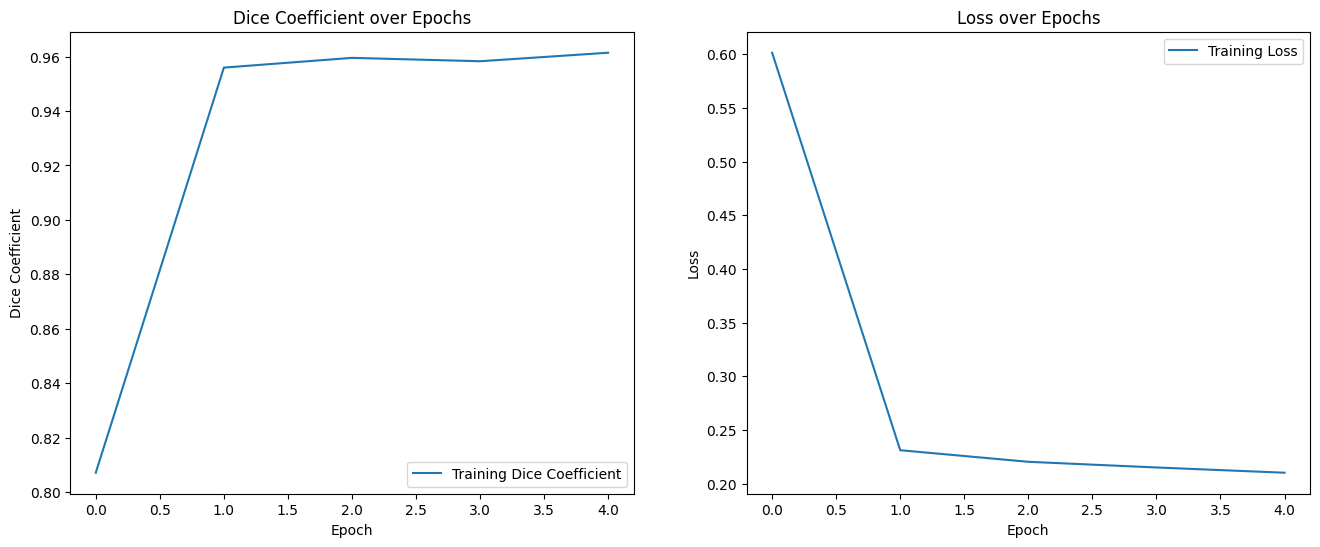

In [8]:
# ==============================================================================
# Step 7: Compile and Train the Model
# ==============================================================================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

# --- Define Custom Metrics and Loss Functions ---

# Metric: Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss Function: A combination of Binary Cross-Entropy and Dice Loss
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    dice = 1 - dice_coefficient(y_true, y_pred)
    return bce(y_true, y_pred) + dice

# Metric: Intersection over Union (IoU)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Compile the Model ---
# We compile the model with the Adam optimizer, our combined loss function, and evaluation metrics.
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, iou_metric, 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# --- Train the Model ---
# Note: For a real project, you should split your data into training and validation sets.
# Here, we train on the full dataset for demonstration purposes.
EPOCHS = 5  #25
print("\nStarting model training...")

history = model.fit(
    train_dataset,
    epochs=EPOCHS
)

print("Model training complete.")

# ==============================================================================
# Step 8: Visualize Training History
# ==============================================================================

# Plotting the training history helps in evaluating model performance over epochs.
plt.figure(figsize=(16, 6))

# Plot training & validation Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Displaying model predictions on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


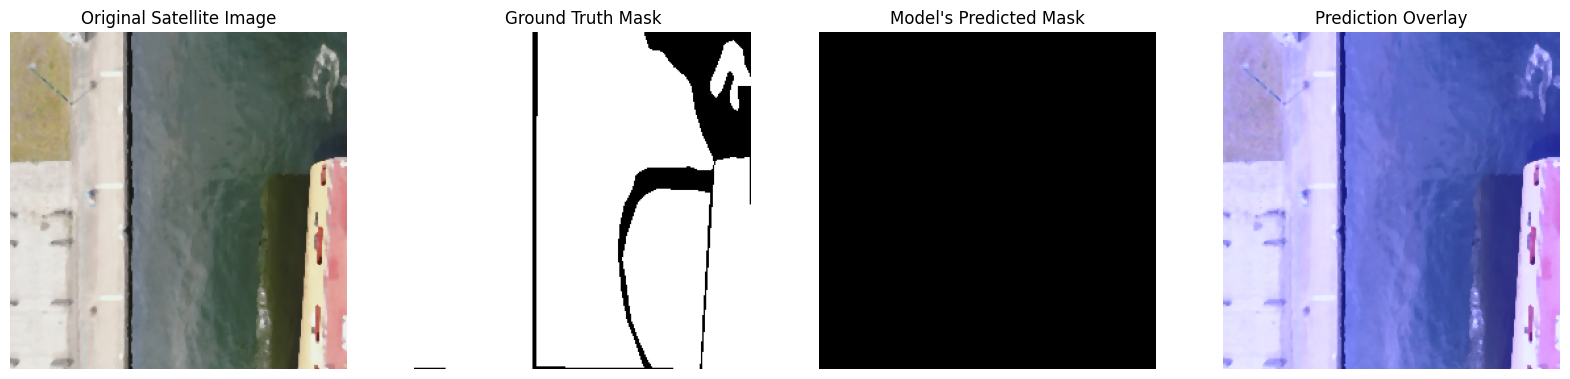

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


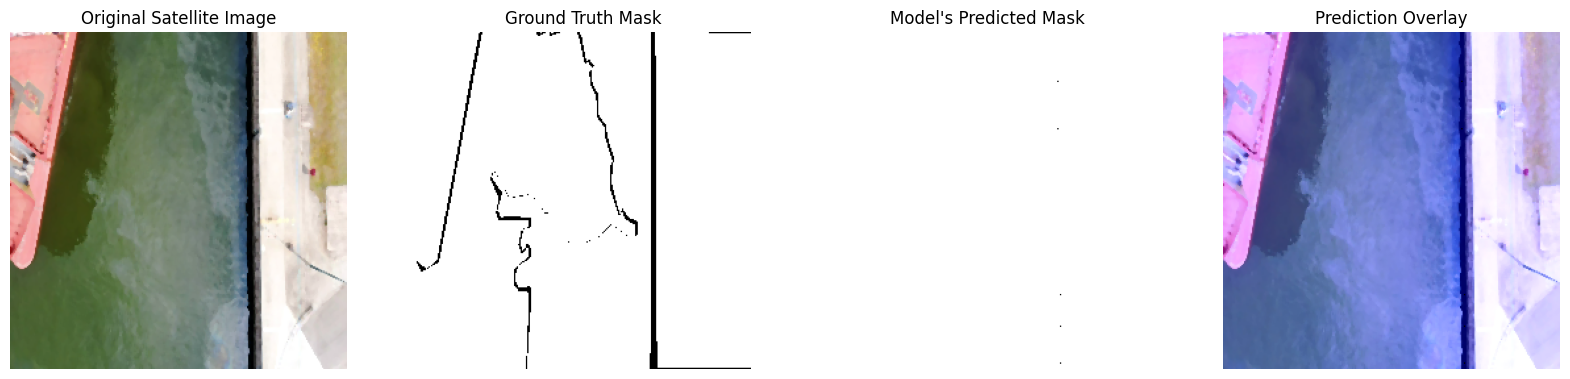

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


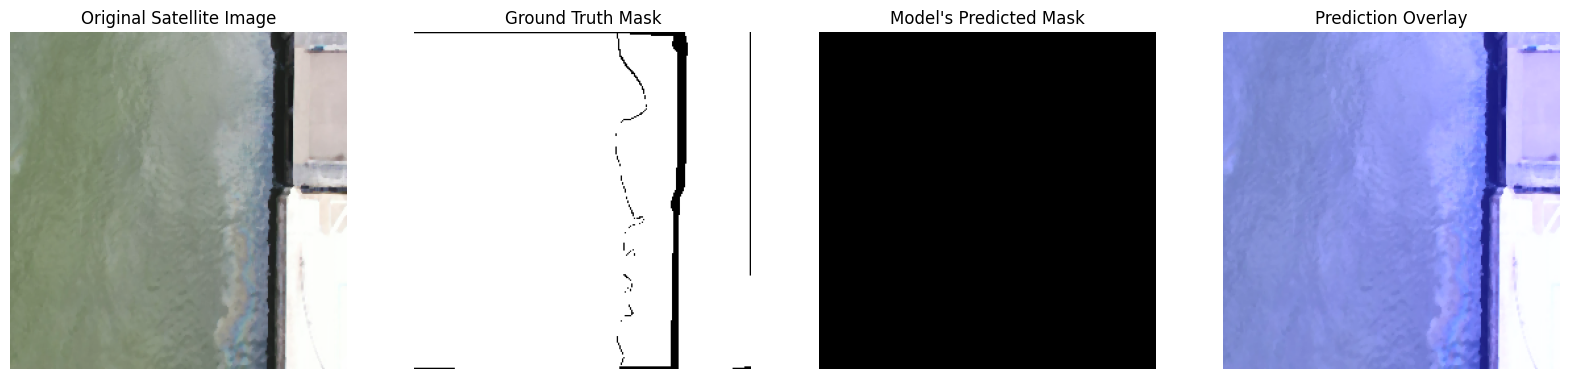

In [9]:
# ==============================================================================
#  Visualization of Results
# ==============================================================================
import numpy as np
import cv2

def display_predictions(model, dataset, num_predictions=3):

    print("\nDisplaying model predictions on sample images...")
    for image, mask in dataset.take(num_predictions):
        # The dataset is batched, so we take the first image from the batch
        # to visualize.
        sample_image = image[0]
        sample_mask = mask[0]

        # Use the trained model to predict the mask for the sample image.

        prediction = model.predict(np.expand_dims(sample_image, axis=0))

        # The model outputs probabilities. We apply a 0.5 threshold to get a binary mask.
        predicted_mask = (prediction[0] > 0.5).astype(np.uint8)


        # --- Create an overlayed image for better visualization ---

        predicted_mask_colored = cv2.cvtColor(predicted_mask * 255, cv2.COLOR_GRAY2BGR)
        predicted_mask_colored[np.where((predicted_mask_colored==[255,255,255]).all(axis=2))] = [0,0,255]

        # Convert the original image tensor back to a displayable format
        original_image_display = (sample_image.numpy() * 255).astype(np.uint8)

        # Blend the original image and the colored mask
        overlayed_image = cv2.addWeighted(original_image_display, 1, predicted_mask_colored, 0.4, 0)

        # --- Display the results ---
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.title("Original Satellite Image")
        plt.imshow(sample_image)
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(tf.squeeze(sample_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Model's Predicted Mask")
        plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Prediction Overlay")
        plt.imshow(overlayed_image)
        plt.axis('off')

        plt.show()


display_predictions(model, train_dataset, num_predictions=3)


Preparing the test dataset...
Test dataset created with 254 images.

Evaluating model performance on the test dataset...
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9565 - dice_coefficient: 0.9566 - iou_metric: 0.9170 - loss: 0.2004 - precision: 0.9565 - recall: 1.0000

--- Final Test Results ---
loss: 0.1803
compile_metrics: 0.9592

Displaying model predictions on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


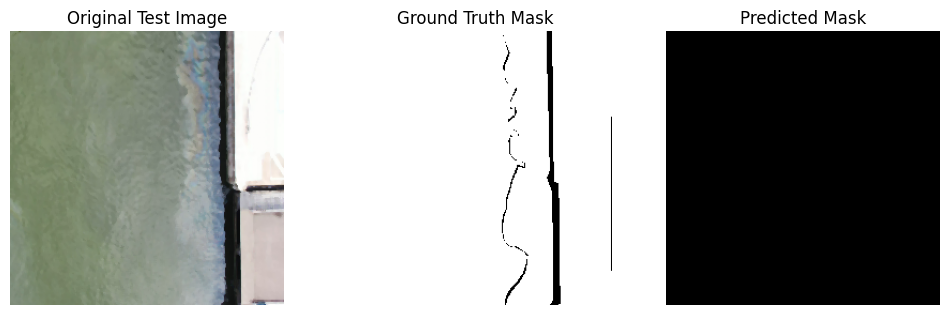

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


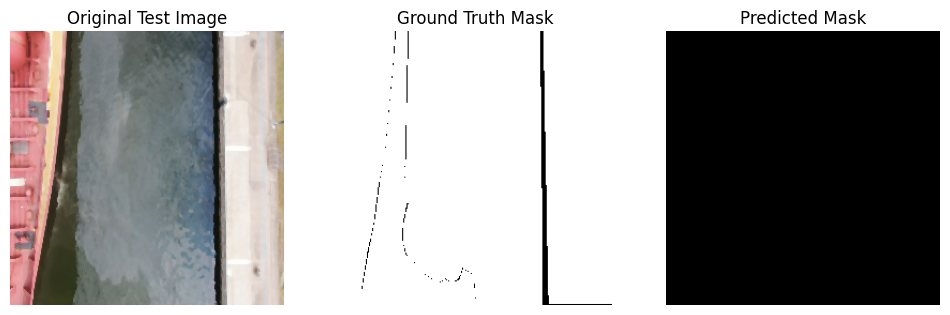

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


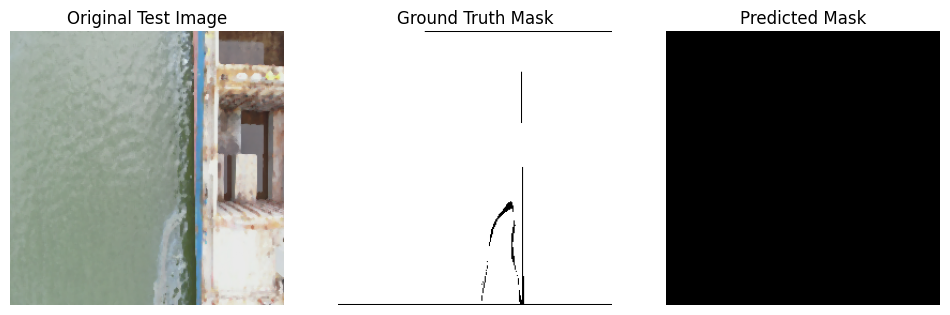

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


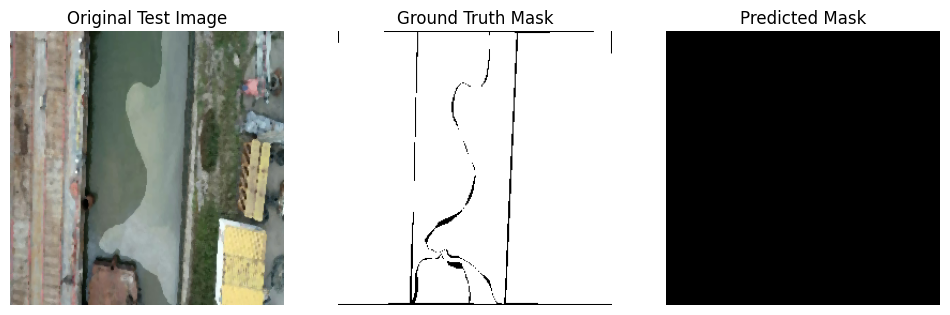

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


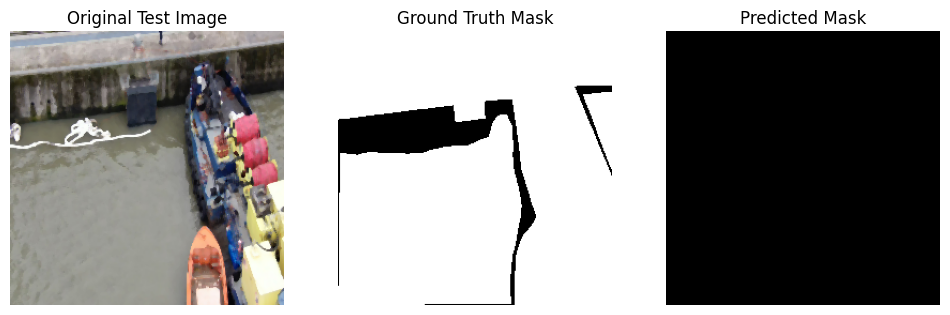


Final trained model saved as 'final_oil_spill_model.h5'


In [10]:
# ==============================================================================
# Final Evaluation and Testing on the Test Dataset
# ==============================================================================

# --- Step 1: Define Paths and Create the Test Dataset ---
print("\nPreparing the test dataset...")
TEST_IMG_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/test/images/'
TEST_MASK_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/test/masks/'

test_image_files = sorted([os.path.join(TEST_IMG_DIR, f) for f in os.listdir(TEST_IMG_DIR)])
test_mask_files = sorted([os.path.join(TEST_MASK_DIR, f) for f in os.listdir(TEST_MASK_DIR)])

# Create the TensorFlow Dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))

# Map the correct function to the dataset
test_dataset = (
    test_dataset
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
print(f"Test dataset created with {len(test_image_files)} images.")

# --- Step 2: Quantitative Evaluation ---
# This calculates the final performance scores (Dice, IoU, etc.) on the entire test set.
print("\nEvaluating model performance on the test dataset...")
results = model.evaluate(test_dataset)

print("\n--- Final Test Results ---")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# --- Step 3: Visual Testing ---
# This shows the model's predictions on a few sample images from the test set.
def display_test_predictions(model, dataset, num_predictions=5):
    print("\nDisplaying model predictions on test images...")
    for image, mask in dataset.take(num_predictions):
        # The dataset is batched, so we take the first image from the batch
        sample_image, sample_mask = image[0], mask[0]

        # Predict the mask
        prediction = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_mask = (prediction[0] > 0.5).astype(np.uint8)

        # Display the results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Test Image")
        plt.imshow(sample_image)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(tf.squeeze(sample_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
        plt.axis('off')

        plt.show()

# Run the visualization on the test dataset
display_test_predictions(model, test_dataset)

# --- Step 4: Optional - Save the Final Model ---
model.save('final_oil_spill_model.h5')
print("\nFinal trained model saved as 'final_oil_spill_model.h5'")

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, confusion_matrix, f1_score
import seaborn as sns


--- Plotting Training History ---


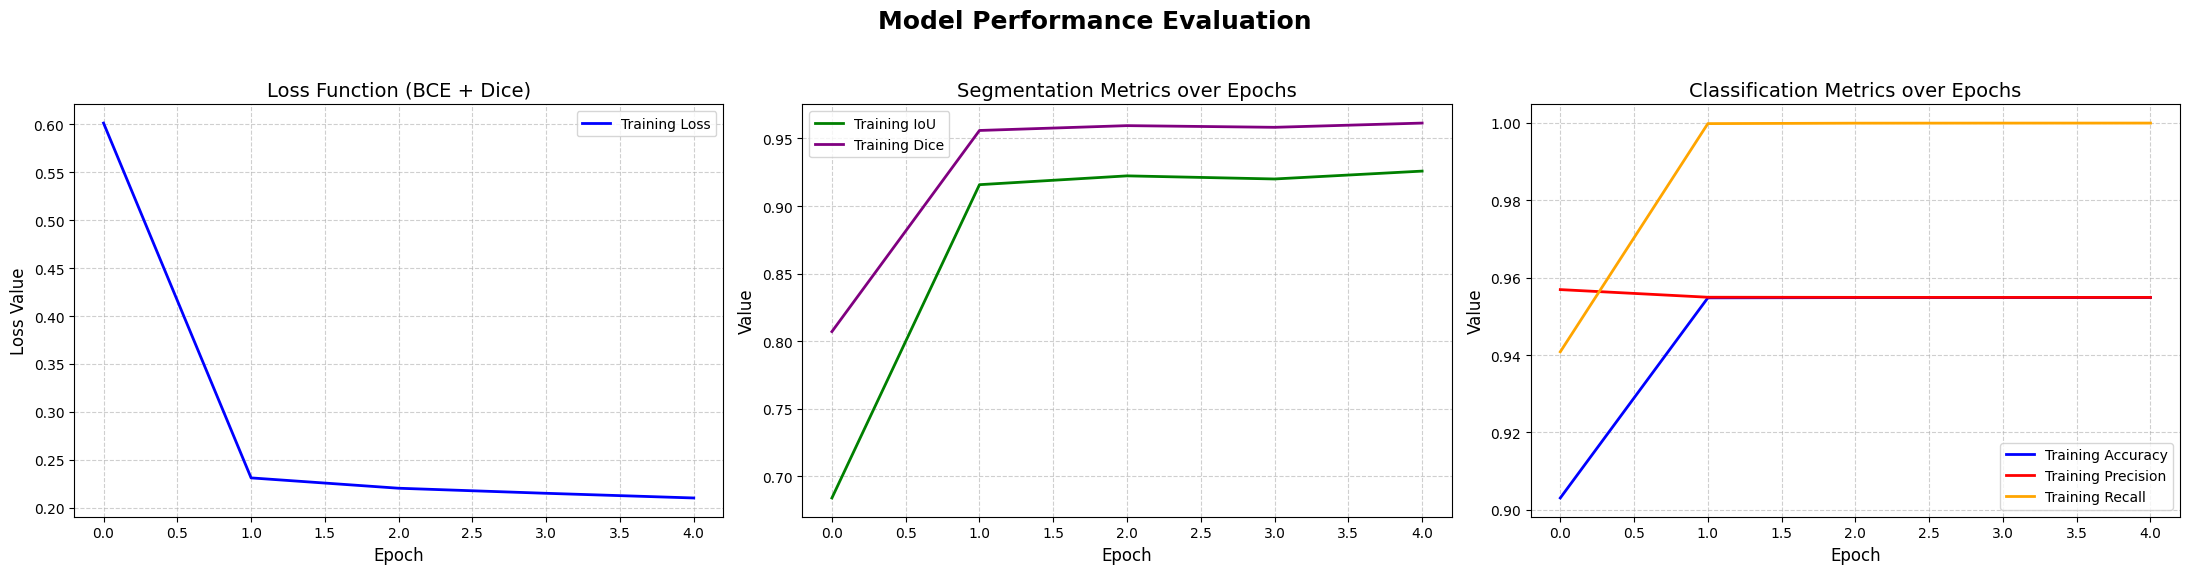

In [29]:
# %%  Function and Call for Plotting Training History
# ==============================================================================
def plot_detailed_history(history):
    """Plots detailed training history."""
    plt.style.use('default')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle('Model Performance Evaluation', fontsize=18, weight='bold')
    # ... (rest of the function code is the same)
    # Plot 1: Loss Function
    ax1.plot(history.history['loss'], label='Training Loss', color='blue', lw=2)
    ax1.set_title('Loss Function (BCE + Dice)', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Segmentation Metrics
    ax2.plot(history.history['iou_metric'], label='Training IoU', color='green', lw=2)
    ax2.plot(history.history['dice_coefficient'], label='Training Dice', color='purple', lw=2)
    ax2.set_title('Segmentation Metrics over Epochs', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Value', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Classification Metrics
    ax3.plot(history.history['accuracy'], label='Training Accuracy', color='blue', lw=2)
    ax3.plot(history.history['precision'], label='Training Precision', color='red', lw=2)
    ax3.plot(history.history['recall'], label='Training Recall', color='orange', lw=2)
    ax3.set_title('Classification Metrics over Epochs', fontsize=14)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Value', fontsize=12)
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n--- Plotting Training History ---")
plot_detailed_history(history)

In [30]:
def get_predictions_and_labels(model, dataset):
    """Helper function to get all predictions and true labels from a dataset."""
    y_true_all, y_pred_all = [], []
    for images, masks in dataset:
        preds = model.predict(images, verbose=0)
        y_true_all.append(masks.numpy().flatten())
        y_pred_all.append(preds.flatten())
    return np.concatenate(y_true_all), np.concatenate(y_pred_all)

In [31]:
# %% Pre-calculate Predictions for Analysis
# ==============================================================================
print("\n--- Calculating all test set predictions (this may take a moment)... ---")
y_true_flat, y_pred_prob_flat = get_predictions_and_labels(model, test_dataset)
print("Cell 4/10: All predictions and labels have been calculated and stored.")



--- Calculating all test set predictions (this may take a moment)... ---
Cell 4/10: All predictions and labels have been calculated and stored.



Generating ROC and Precision-Recall Curves...


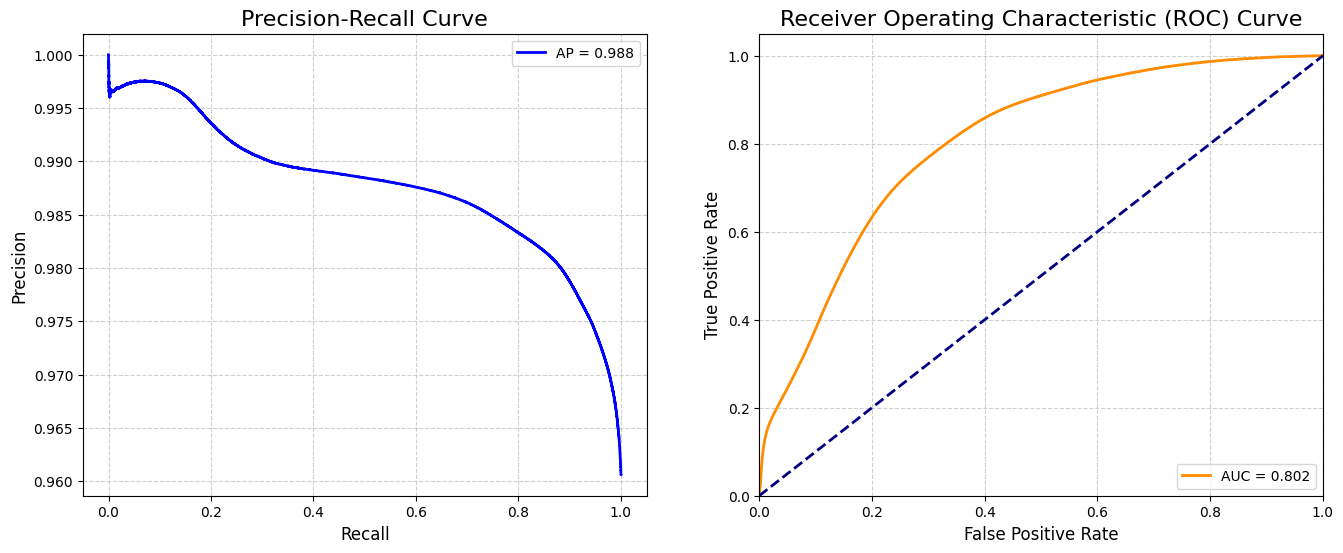

In [32]:
# %% Function and Call for ROC and Precision-Recall Curves
# ==============================================================================
def plot_roc_and_pr_curves(y_true, y_pred_prob):
    """Calculates and plots both the ROC and Precision-Recall curves."""
    print("\nGenerating ROC and Precision-Recall Curves...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    # ... (rest of the function code is the same)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    avg_precision = average_precision_score(y_true, y_pred_prob)
    ax1.plot(recall, precision, lw=2, label=f'AP = {avg_precision:.3f}', color='blue')
    ax1.set_xlabel('Recall', fontsize=12)
    ax1.set_ylabel('Precision', fontsize=12)
    ax1.set_title('Precision-Recall Curve', fontsize=16)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax2.legend(loc="lower right")
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_roc_and_pr_curves(y_true_flat, y_pred_prob_flat)


Generating Confusion Matrix and Metrics Summary...

--- Pixel-wise Classification Metrics Summary ---
-------------------------------------------------
Accuracy:    0.9606
Precision:   0.9606
Recall:      1.0000
Specificity: 0.0000
F1-Score:    0.9799
IoU/Jaccard: 0.9606
Dice Coeff:  0.9799
-------------------------------------------------


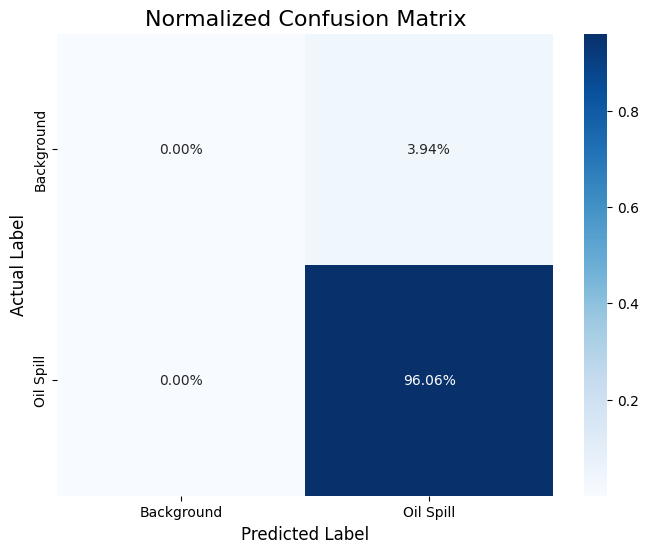

In [33]:
# %% Function and Call for Confusion Matrix and Metrics Summary
# ==============================================================================
def plot_confusion_matrix_and_summary(y_true, y_pred_prob, threshold=0.5):
    """Calculates and displays a confusion matrix and a summary of metrics."""
    # ... (rest of the function code is the same)
    print("\nGenerating Confusion Matrix and Metrics Summary...")
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)

    with np.errstate(divide='ignore', invalid='ignore'):
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    print("\n--- Pixel-wise Classification Metrics Summary ---")
    print("-------------------------------------------------")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score:    {f1_score:.4f}")
    print(f"IoU/Jaccard: {iou:.4f}")
    print(f"Dice Coeff:  {dice:.4f}")
    print("-------------------------------------------------")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Background', 'Oil Spill'], yticklabels=['Background', 'Oil Spill'])
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

plot_confusion_matrix_and_summary(y_true_flat, y_pred_prob_flat)


Analyzing Prediction Confidence...


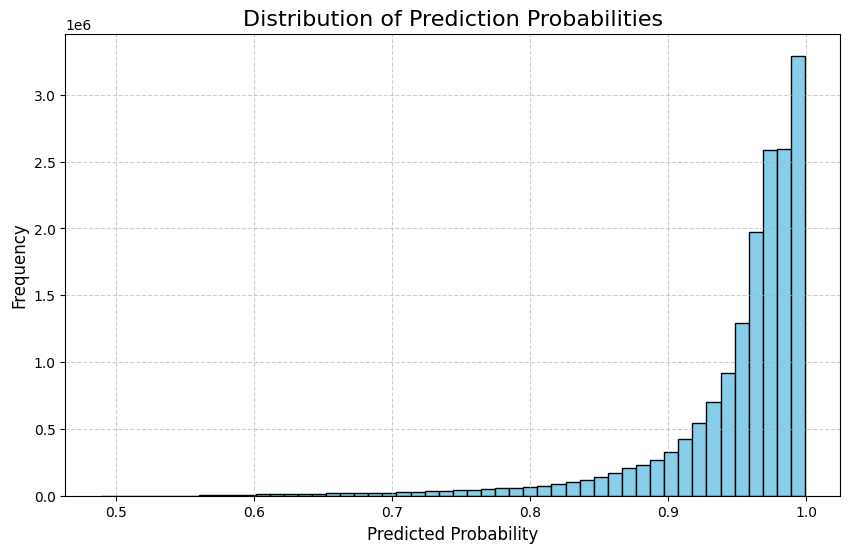

In [34]:
# %%  Function and Call for Prediction Confidence Histogram
# ==============================================================================
def plot_prediction_confidence(y_pred_prob):
    """Plots a histogram of the model's prediction probabilities."""
    print("\nAnalyzing Prediction Confidence...")
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_prob, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Prediction Probabilities', fontsize=16)
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_prediction_confidence(y_pred_prob_flat)

In [35]:
# %% Function Definition for Detailed Prediction Visualization
# ==============================================================================
def display_detailed_predictions(image_batch, mask_batch, model, title_prefix=""):
    """Displays a single detailed prediction with overlays and an error map."""
    # ... (rest of the function code is the same)
    pred_mask_prob = model.predict(tf.expand_dims(image_batch, 0), verbose=0)[0]
    pred_mask = (pred_mask_prob > 0.5).astype(np.uint8)
    original_image = (image_batch.numpy() * 255).astype(np.uint8)
    true_mask = mask_batch.numpy().squeeze().astype(np.uint8)
    pred_mask = pred_mask.squeeze()
    true_mask_overlay = cv2.cvtColor(true_mask * 255, cv2.COLOR_GRAY2BGR)
    true_mask_overlay[np.where((true_mask_overlay == [255, 255, 255]).all(axis=2))] = [255, 0, 0] # Red
    ground_truth_viz = cv2.addWeighted(original_image, 1, true_mask_overlay, 0.5, 0)
    pred_mask_overlay = cv2.cvtColor(pred_mask * 255, cv2.COLOR_GRAY2BGR)
    pred_mask_overlay[np.where((pred_mask_overlay == [255, 255, 255]).all(axis=2))] = [0, 255, 0] # Green
    prediction_viz = cv2.addWeighted(original_image, 1, pred_mask_overlay, 0.5, 0)
    error_map = np.zeros_like(original_image)
    tp = (true_mask == 1) & (pred_mask == 1)
    fp = (true_mask == 0) & (pred_mask == 1)
    fn = (true_mask == 1) & (pred_mask == 0)
    error_map[tp] = [255, 255, 0]  # Yellow for True Positives
    error_map[fp] = [255, 0, 0]    # Red for False Positives
    error_map[fn] = [0, 0, 255]    # Blue for False Negatives
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(title_prefix, fontsize=16)
    axes[0].imshow(original_image); axes[0].set_title("1. Original Image"); axes[0].axis('off')
    axes[1].imshow(ground_truth_viz); axes[1].set_title("2. Ground Truth"); axes[1].axis('off')
    axes[2].imshow(pred_mask, cmap='gray'); axes[2].set_title("3. Predicted Mask"); axes[2].axis('off')
    axes[3].imshow(prediction_viz); axes[3].set_title("4. Prediction Overlay"); axes[3].axis('off')
    axes[4].imshow(error_map); axes[4].set_title("5. Error Map"); axes[4].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



--- Displaying Random Good Predictions ---


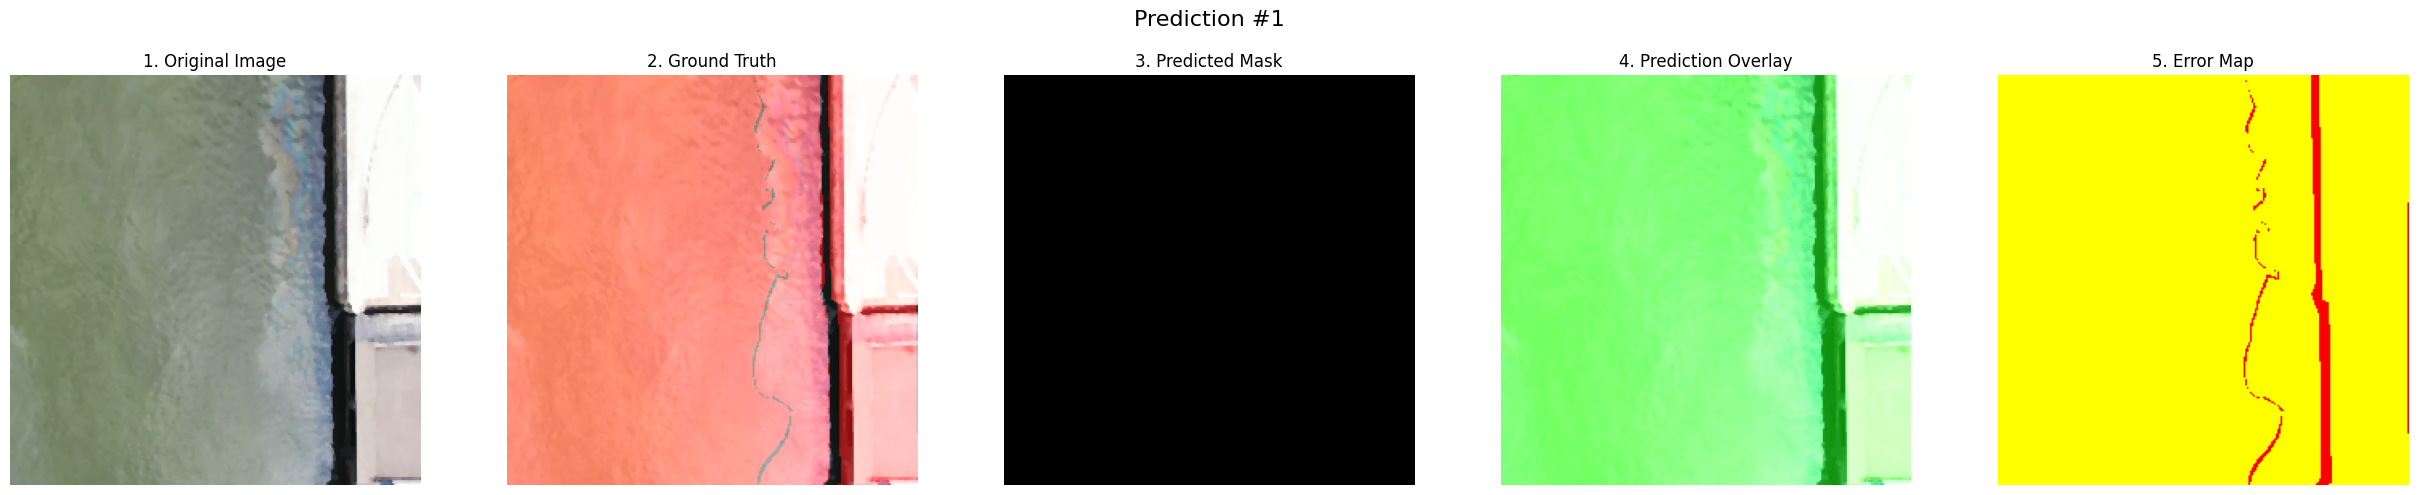

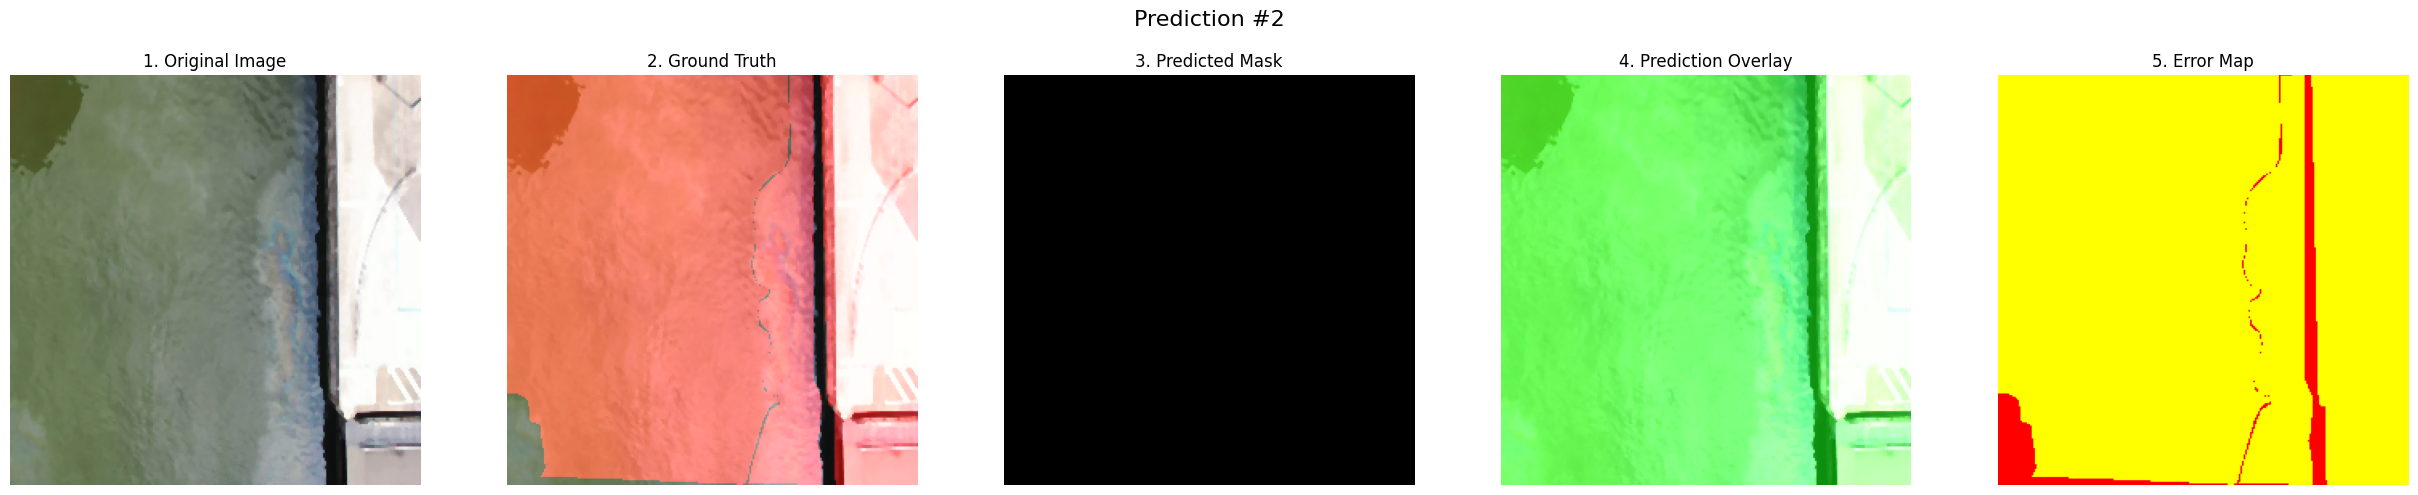

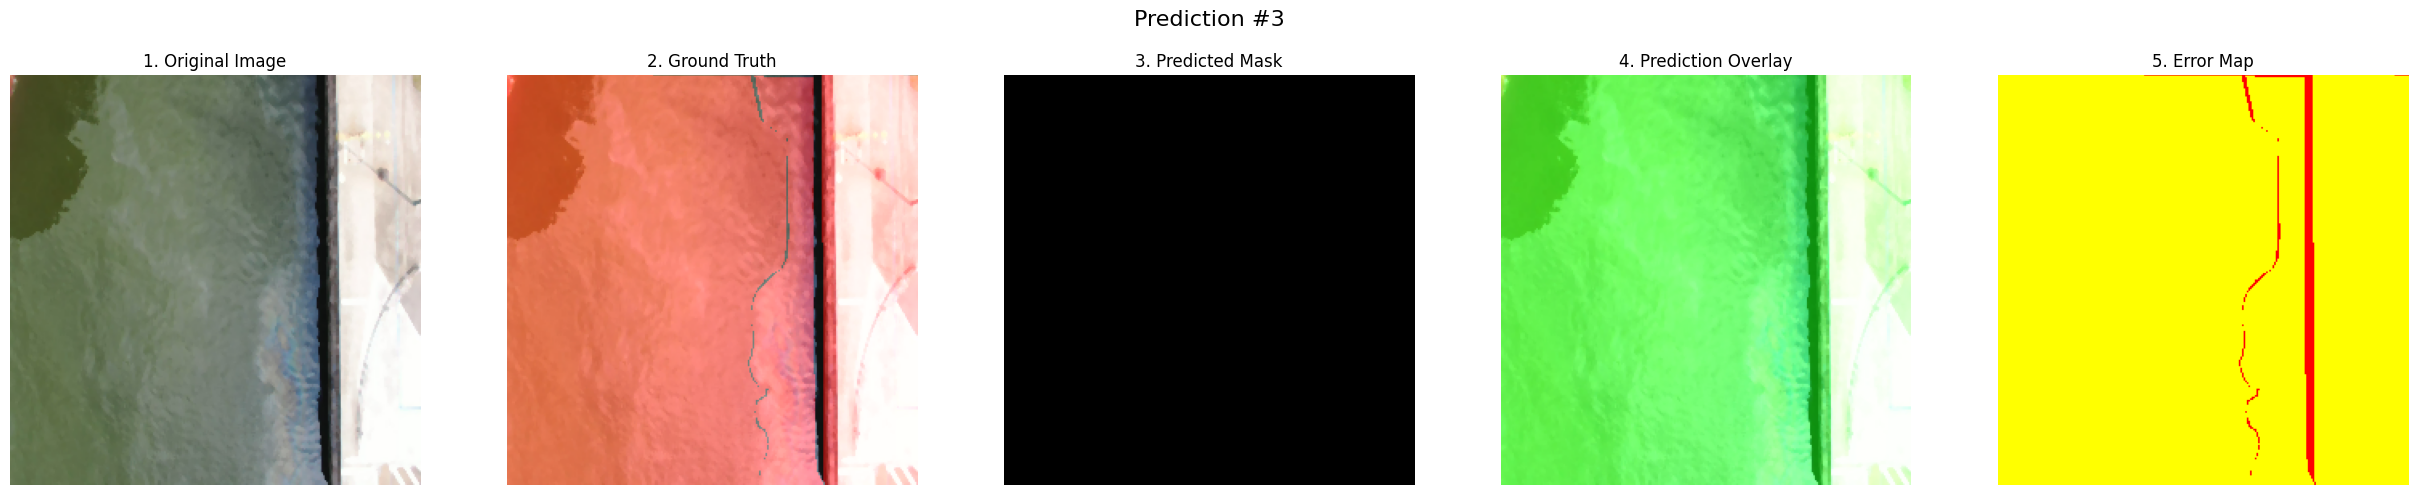

In [36]:
# %% Displaying a Few Sample Predictions
# ==============================================================================
print("\n--- Displaying Random Good Predictions ---")
for i, (img, msk) in enumerate(test_dataset.unbatch().take(3)):
    display_detailed_predictions(img, msk, model, title_prefix=f"Prediction #{i+1}")


Identifying the 3 worst predictions...

Displaying Worst Performing Samples (Lowest Dice Score)...


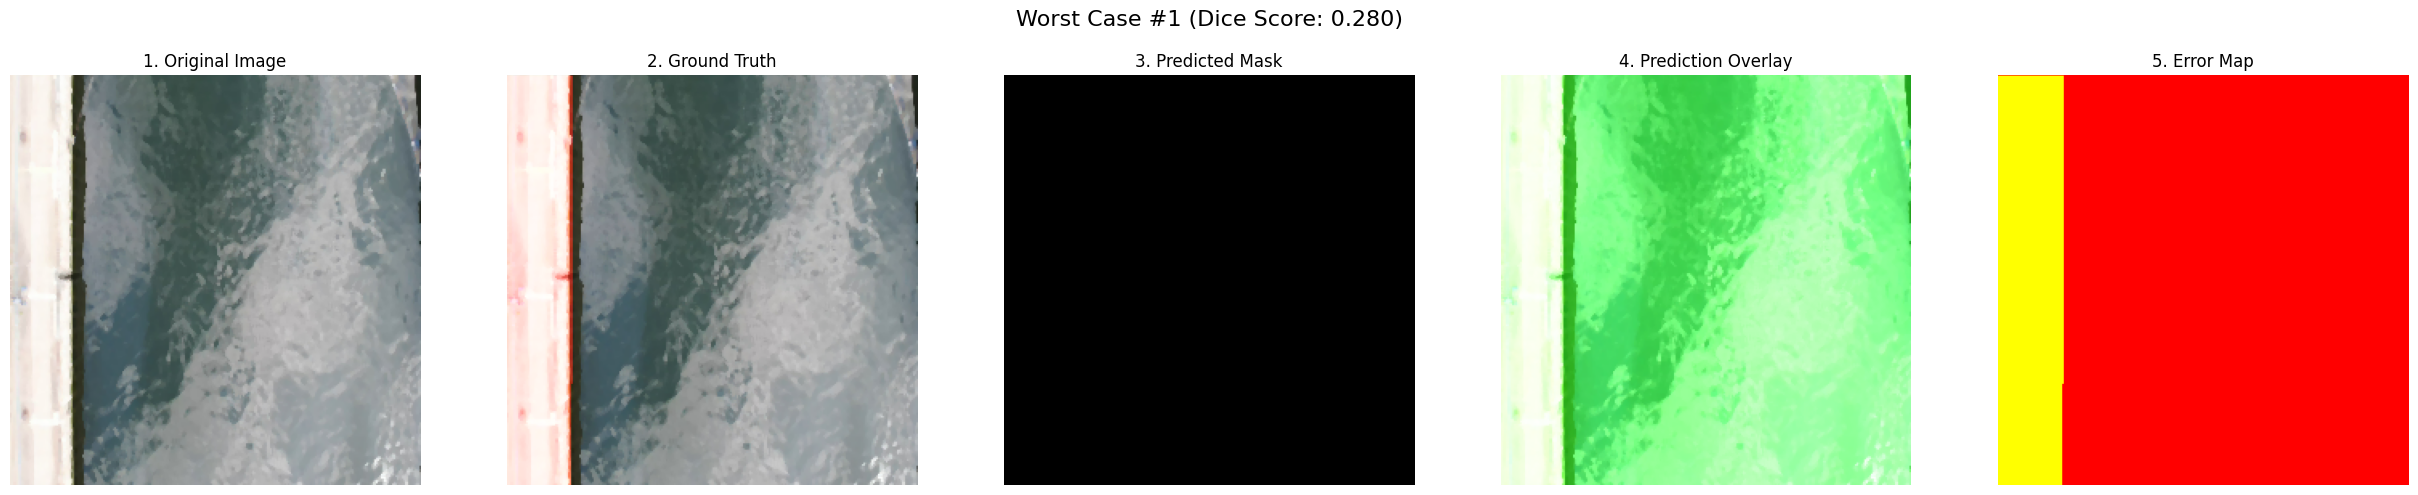

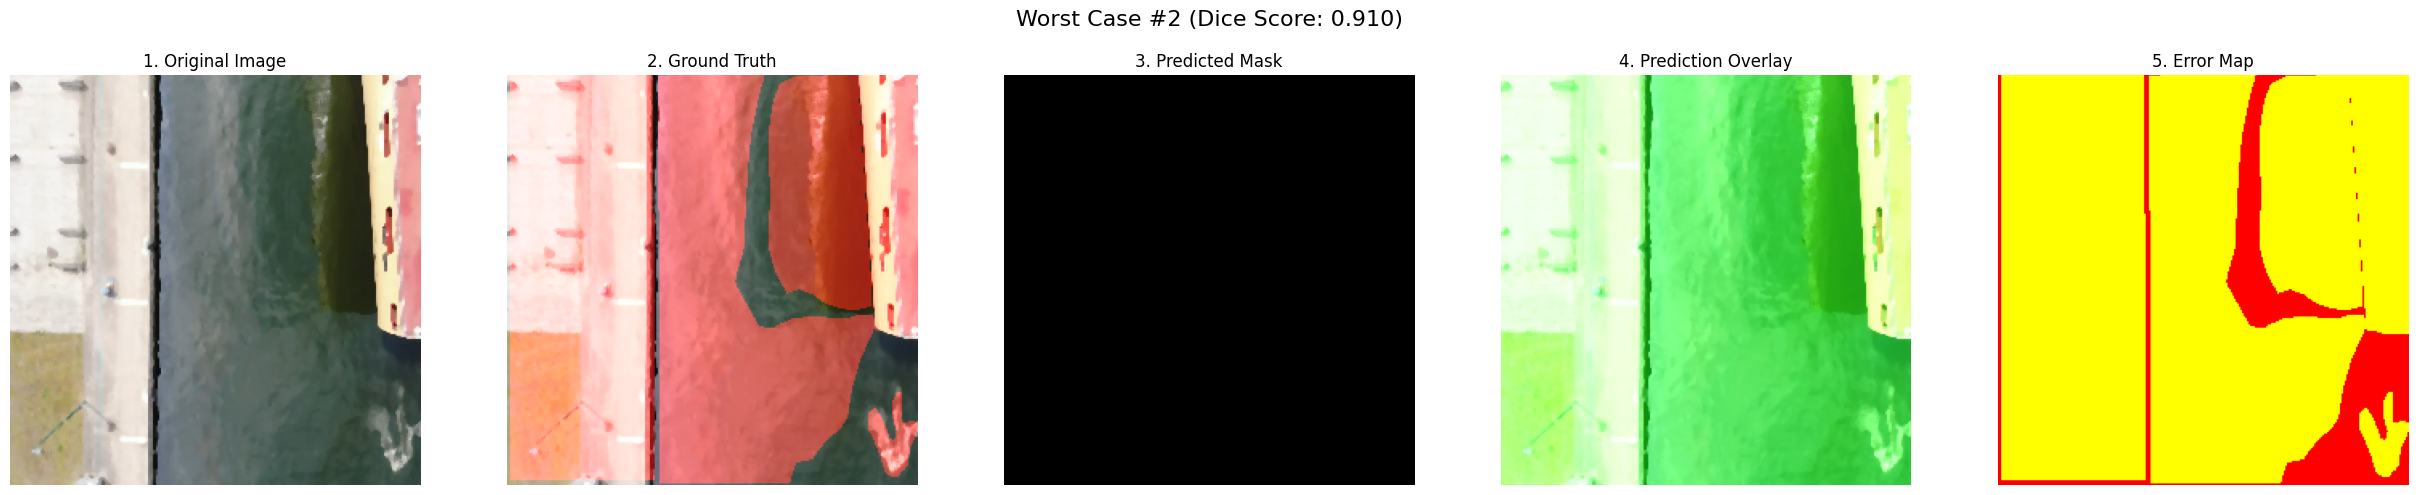

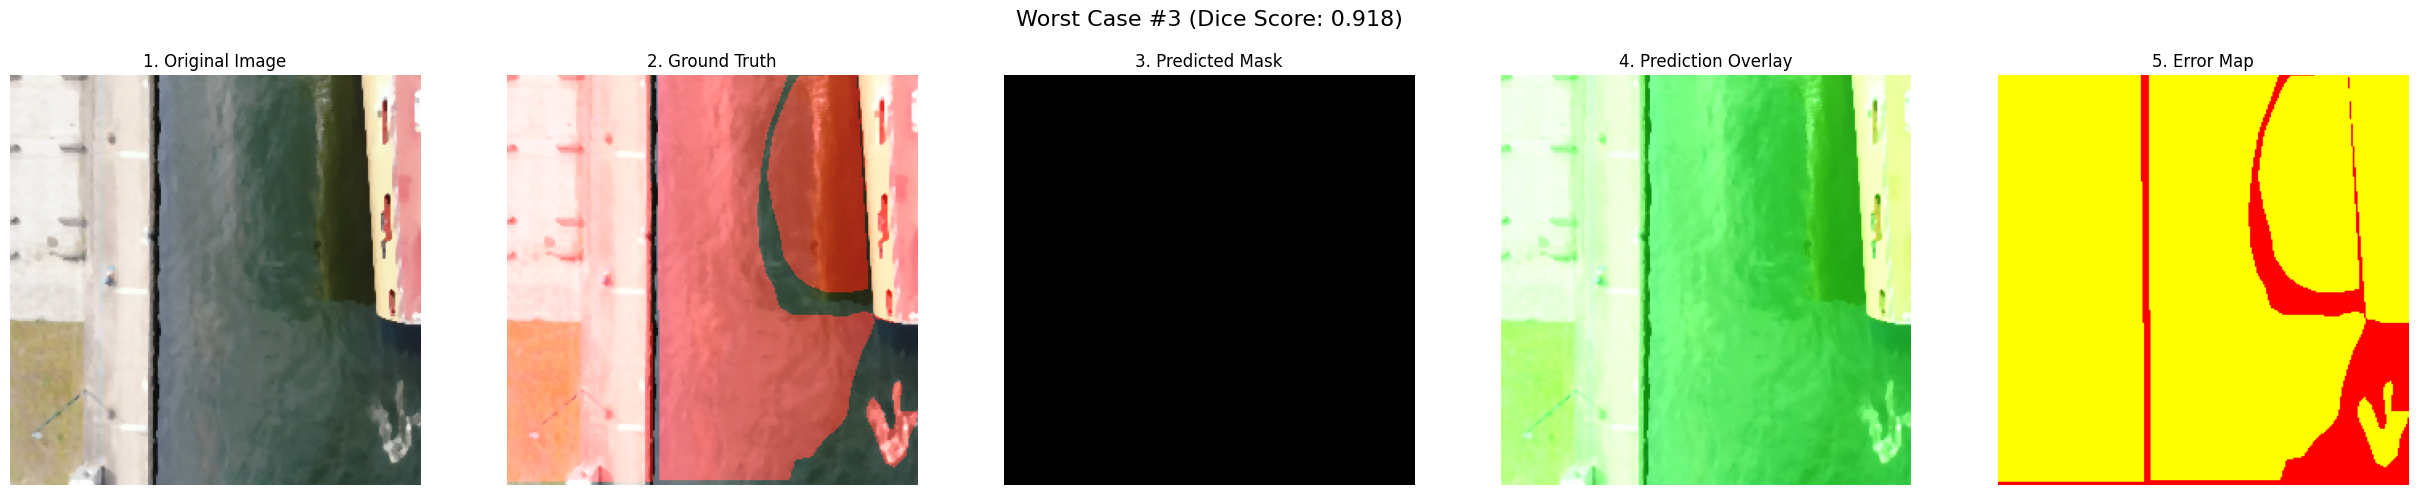


--- End of Visualization ---


In [37]:
# %% Function and Call for Worst-Case Analysis
# ==============================================================================
def display_worst_predictions(model, dataset, num_to_show=5):
    """Finds and displays the predictions with the lowest Dice scores."""
    print(f"\nIdentifying the {num_to_show} worst predictions...")
    scores = []
    samples = []
    for image, mask in dataset.unbatch():
        pred_prob = model.predict(tf.expand_dims(image, 0), verbose=0)[0]
        y_true_f = tf.cast(tf.reshape(mask, [-1]), tf.float32)
        y_pred_f = tf.reshape(pred_prob, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice = (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
        scores.append(dice.numpy())
        samples.append((image, mask))
    sorted_indices = np.argsort(scores)

    print("\nDisplaying Worst Performing Samples (Lowest Dice Score)...")
    for i in range(num_to_show):
        idx = sorted_indices[i]
        image, mask = samples[idx]
        title = f"Worst Case #{i+1} (Dice Score: {scores[idx]:.3f})"
        display_detailed_predictions(image, mask, model, title_prefix=title)

display_worst_predictions(model, test_dataset, num_to_show=3)
print("\n--- End of Visualization ---")